1. load model
2. load test data
3. get prediction along with attention map
4. visualize input with attention map

In [1]:
import sys
import torch
import numpy as np
sys.path.append('../..')
from multi_modal_heart.model.ecg_net_attention import ECGEncoder,ECGAttentionAE
from multi_modal_heart.model.ecg_net import ECGAE




In [2]:

import pytorch_lightning as pl
from multi_modal_heart.model.ecg_net import BenchmarkClassifier

class LitClassifier(pl.LightningModule):
    def __init__(self,encoder,input_dim,num_classes=5):
        super().__init__()
        
        self.encoder = encoder
        #### add classifier if use benchmark classifier
        self.downsteam_net = BenchmarkClassifier(input_size=input_dim,hidden_size=128,output_size=num_classes)
        self.save_hyperparameters()

    def forward(self, x, mask):
        latent_code = self.encoder.get_features_after_pooling(x,mask)
        return self.downsteam_net(latent_code)
    
class LitAE(pl.LightningModule):
    def __init__(self,network,input_dim,num_classes=5):
        super().__init__()
        
        self.network = network
        #### add classifier if use benchmark classifier
        # self.downsteam_net = BenchmarkClassifier(input_size=input_dim,hidden_size=128,output_size=num_classes)
        # self.save_hyperparameters()

    def forward(self, x):
        return self.network(x)
# resnet_checkpoint = '../../log_finetune/resnet1d101_512+benchmark_classifier_ms_resnet/checkpoints/epoch=37-step=5168.ckpt'
# ecg_net= ECGAE(encoder_type="resnet1d101",in_channels=12,ECG_length=1024,decoder_type="ms_resnet",
#                     embedding_dim=256,latent_code_dim=512,
#                     add_time=False,
#                     encoder_mha = False,
#                     apply_method="",
#                     decoder_outdim=12)
# classification_net = LitClassifier(encoder=ecg_net.encoder,input_dim=512,num_classes=5)
# classification_net.load_from_checkpoint(resnet_checkpoint,strict=True)


In [58]:
ecg_net = ECGAttentionAE(num_leads=12, time_steps=1024, z_dims=512, linear_out=512, downsample_factor=5, base_feature_dim=4,if_VAE=False,use_attention_pool=False,
                         no_linear_in_E=True, apply_lead_mask=False)
classification_net = LitClassifier(encoder=ecg_net.encoder,input_dim=512,num_classes=5)

# use_median_wave = False
# # checkpoint_path = "../../log_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_ms_resnet/checkpoints/epoch=49-val_auroc:benchmark_classifier/val_macro_auc=0.90.ckpt"
# checkpoint_path = "../../log_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_ms_resnet_ECG2Text/checkpoints/checkpoint_best_loss.ckpt"
# checkpoint_path = "../../log_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_ms_resnet/checkpoints/epoch=49-val_auroc:benchmark_classifier/val_macro_auc=0.90.ckpt"

use_median_wave = True
time_steps = 608
ecg_net = ECGAttentionAE(num_leads=12, time_steps=time_steps, z_dims=512, linear_out=512, downsample_factor=5, base_feature_dim=4,if_VAE=False,use_attention_pool=False,
                         no_linear_in_E=True, apply_lead_mask=False)
classification_net = LitClassifier(encoder=ecg_net.encoder,input_dim=512,num_classes=5)

checkpoint_path = "../../log_median_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_ms_resnet/checkpoints/checkpoint_best_loss.ckpt"
print (torch.load(checkpoint_path)["state_dict"].keys())
mm_checkpoint = torch.load(checkpoint_path)["state_dict"]
encoder_params = {(".").join(key.split(".")[1:]):value for key, value in mm_checkpoint.items() if str(key).startswith("encoder")}
classification_params = {(".").join(key.split(".")[1:]):value for key, value in mm_checkpoint.items() if str(key).startswith("downsteam_net")}
classification_net.encoder.load_state_dict(encoder_params)
classification_net.downsteam_net.load_state_dict(classification_params)


no linear layer
no linear layer
odict_keys(['encoder.input_conv.0.weight', 'encoder.input_conv.0.bias', 'encoder.input_conv.1.weight', 'encoder.input_conv.1.bias', 'encoder.input_conv.3.weight', 'encoder.input_conv.3.bias', 'encoder.input_conv.4.weight', 'encoder.input_conv.4.bias', 'encoder.encoder.0.conv1.weight', 'encoder.encoder.0.bn1.weight', 'encoder.encoder.0.bn1.bias', 'encoder.encoder.0.bn1.running_mean', 'encoder.encoder.0.bn1.running_var', 'encoder.encoder.0.bn1.num_batches_tracked', 'encoder.encoder.0.conv2.weight', 'encoder.encoder.0.bn2.weight', 'encoder.encoder.0.bn2.bias', 'encoder.encoder.0.bn2.running_mean', 'encoder.encoder.0.bn2.running_var', 'encoder.encoder.0.bn2.num_batches_tracked', 'encoder.encoder.0.idfunc_1.weight', 'encoder.encoder.0.idfunc_1.bias', 'encoder.encoder.1.conv1.weight', 'encoder.encoder.1.bn1.weight', 'encoder.encoder.1.bn1.bias', 'encoder.encoder.1.bn1.running_mean', 'encoder.encoder.1.bn1.running_var', 'encoder.encoder.1.bn1.num_batches_tracke

<All keys matched successfully>

In [4]:
import torch
import sys
sys.path.append('../../')
from multi_modal_heart.model.ecg_net import ECGAE
resnet_checkpoint = '../../log_finetune/resnet1d101_512+benchmark_classifier_ms_resnet/checkpoints/epoch=23-val_auroc:benchmark_classifier/val_macro_auc=0.91.ckpt'
checkpoint = torch.load(resnet_checkpoint)["state_dict"]
print(checkpoint.keys())

ecg_net= ECGAE(encoder_type="resnet1d101",in_channels=12,ECG_length=1024,decoder_type="ms_resnet",
                    embedding_dim=256,latent_code_dim=512,
                    add_time=False,
                    encoder_mha = False,
                    apply_method="",
                    decoder_outdim=12)
classification_net = LitClassifier(encoder=ecg_net.encoder,input_dim=512,num_classes=5)
encoder_params = {(".").join(key.split(".")[1:]):value for key, value in checkpoint.items() if str(key).startswith("encoder")}
classification_params = {(".").join(key.split(".")[1:]):value for key, value in checkpoint.items() if str(key).startswith("downsteam_net")}
classification_net.encoder.load_state_dict(encoder_params)
classification_net.downsteam_net.load_state_dict(classification_params)


odict_keys(['encoder.encoder.0.0.0.weight', 'encoder.encoder.0.0.1.weight', 'encoder.encoder.0.0.1.bias', 'encoder.encoder.0.0.1.running_mean', 'encoder.encoder.0.0.1.running_var', 'encoder.encoder.0.0.1.num_batches_tracked', 'encoder.encoder.0.1.0.weight', 'encoder.encoder.0.1.1.weight', 'encoder.encoder.0.1.1.bias', 'encoder.encoder.0.1.1.running_mean', 'encoder.encoder.0.1.1.running_var', 'encoder.encoder.0.1.1.num_batches_tracked', 'encoder.encoder.0.2.0.weight', 'encoder.encoder.0.2.1.weight', 'encoder.encoder.0.2.1.bias', 'encoder.encoder.0.2.1.running_mean', 'encoder.encoder.0.2.1.running_var', 'encoder.encoder.0.2.1.num_batches_tracked', 'encoder.encoder.0.4.0.convs.0.0.weight', 'encoder.encoder.0.4.0.convs.0.1.weight', 'encoder.encoder.0.4.0.convs.0.1.bias', 'encoder.encoder.0.4.0.convs.0.1.running_mean', 'encoder.encoder.0.4.0.convs.0.1.running_var', 'encoder.encoder.0.4.0.convs.0.1.num_batches_tracked', 'encoder.encoder.0.4.0.convs.1.0.weight', 'encoder.encoder.0.4.0.convs.1

<All keys matched successfully>

In [59]:
## build classification network

## start training
import os
import sys
sys.path.append('../../')
from torch.utils.data import DataLoader
from multi_modal_heart.ECG.ecg_dataset import ECGDataset
## initialize a dataloader (all data)
data_folder = "/home/engs2522/project/multi-modal-heart/multi_modal_heart/data/ptbxl/"
test_data_statement_path = os.path.join(data_folder,"/home/engs2522/project/multi-modal-heart/multi_modal_heart/data/ptbxl/raw_split/Y_test.csv")


data_loaders = []
sampling_rate=500 if use_median_wave else 100
batch_size  = 128
max_seq_len = 608 if use_median_wave else 1024
data_proc_config={
                "if_clean":False,
                 }
data_aug_config={
                "noise_frequency_list":[5,20,100,150,175],
                "noise_amplitude_range":[0.,0.2],
                "powerline_frequency_list":[50],
                "powerline_amplitude_range":[0.,0.05],
                "artifacts_amplitude_range":[0.,0.1],
                "artifacts_frequency_list":[5,10],
                "artifacts_number_range":[0,3],
                "linear_drift_range":[0.,0.1],
                "random_prob":0.5,
                "if_mask_signal":True, 
                "mask_whole_lead_prob":0.2,
                "lead_mask_prob":0.2,
                "region_mask_prob":0.15,
                "mask_length_range":[0.08, 0.18],
                "mask_value":0.0,
                
}
dataset = ECGDataset(data_folder,label_csv_path=test_data_statement_path,
                         use_median_wave=use_median_wave, ## set to median wave, then it has 600 samples for each lead, when sampling rate is 100
                          sampling_rate=sampling_rate,
                          max_seq_len=max_seq_len,
                          augmentation= False,
                          data_proc_config=data_proc_config,
                          data_aug_config=data_aug_config,)
data_loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            num_workers=0,
                            shuffle = False,
                            drop_last= False,
                            )
print ('load {} data: {} samples'.format(test_data_statement_path.split("/")[-1],len(dataset)))
    
dataset.super_classes_labels

load Y_test.csv data: 2155 samples


array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object)

In [60]:
def print_result(probs,super_classes_labels, topk=1):
    probs, label_indices = torch.topk(probs, topk)
    probs = probs.tolist()
    label_indices = label_indices.tolist()
    for prob, idx in zip(probs, label_indices):
        label = super_classes_labels[idx]
        print(f'{label} ({idx}):', round(prob, 4))

In [61]:
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics.classification import MultilabelAUROC
from tqdm.notebook import tqdm
metric = MultilabelAccuracy(num_labels=5)
auroc = MultilabelAUROC(num_labels=5)
classification_net.eval()
classification_net.freeze()
for i, data in enumerate(tqdm(data_loader)):
    # if i==5: break
    torch.cuda.empty_cache()
    # ecg_id= data['ecg_id']
    input_data=data["input_seq"]
    print (input_data.shape)
    mask =  data["mask"]
    # # ## remove lead 3- data
    # mask_lead_ids = [1,2,3,4,5,6,7,8,9,10,11]
    # mask_lead_ids = [0,2,3,4,5,6,7,8,9,10,11]
    mask_lead_ids = []
    input_data[:,mask_lead_ids] = torch.zeros_like(input_data[:,mask_lead_ids])
    mask[:,mask_lead_ids] = torch.zeros_like(mask[:,mask_lead_ids])
    pred = classification_net(input_data, mask)
    report   =data["report"]
    pred = torch.sigmoid(pred)
    ground_truth = data["super_class_encoding"]
    # print (ground_truth.shape)
    acc = metric.update(pred, ground_truth.long())
    auroc_score = auroc.update(pred, ground_truth.long())
    try:
        lead_attention,time_attention = classification_net.encoder.get_attention()
    except:
        pass
    if i==0:
        break
    # print (report[5:10])
    # print (pred[5:10])
    # print (ground_truth[5:10])
acc = metric.compute()
print ('acc:', acc)
auroc_score = auroc.compute()
print ('auroc:',auroc_score)
    # if ground_truth[0][0]==1:
    #     break


  0%|          | 0/17 [00:00<?, ?it/s]

torch.Size([128, 12, 608])
acc: tensor(0.9094)
auroc: tensor(0.9315)


In [101]:
indices = 67
output_probs = pred[indices]
gt_labels = dataset.super_classes_labels[ground_truth[indices]==1]
print ("GT labels",gt_labels)
print ("ecg id",data["ecg_id"][indices])
print ("Predicted labels")
print_result(output_probs, dataset.super_classes_labels,topk=5)
print ("Report:",report[indices])




GT labels ['HYP' 'STTC']
ecg id tensor(516)
Predicted labels
STTC (4): 0.9561
HYP (1): 0.9461
CD (0): 0.0556
MI (2): 0.0366
NORM (3): 0.0017
Report: sinusrytm ospecifikt skÄnkelblock vÄnster kammarhypertrofi Edit: LVH 100, ISC, Sokolow 9(LVH 100, ISC_)


In [105]:
## get attention map (num_lead=12, batch_size=128, n_features*signal_length)
print(lead_attention.shape) ## (num_lead*num_lead)
# normalize attention map
leadwise_attention_map = lead_attention[indices]
normalized_attention = leadwise_attention_map
normalized_attention = leadwise_attention_map/leadwise_attention_map.sum(dim=1,keepdim=True)
print (normalized_attention.shape)

torch.Size([128, 12, 12])
torch.Size([12, 12])


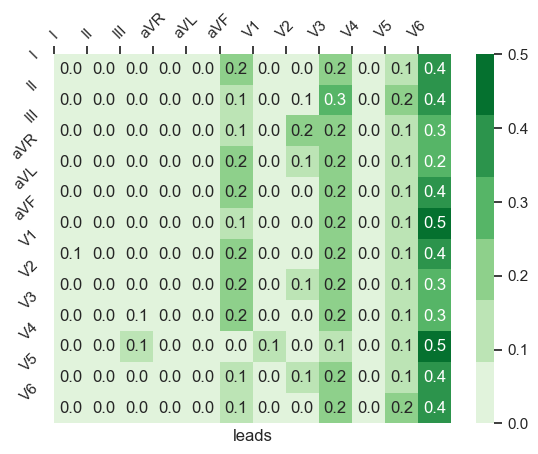

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
x_ticks = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]
# cmap  =sns.palplot(sns.color_palette("Blues",12))
colormap = sns.color_palette("Greens")

sns.heatmap(normalized_attention.cpu().detach().numpy(),cmap=colormap,fmt=".1f",annot=True,xticklabels=x_ticks,yticklabels=x_ticks)

## change xticks
plt.xticks(np.arange(0,12),x_ticks,rotation=45)
plt.xlabel("leads")
## change yticks
plt.yticks(np.arange(0,12),x_ticks,rotation=45)
## put x ticks on the top
ax = plt.gca()
ax.xaxis.tick_top()

12
torch.Size([128, 19, 19])
torch.Size([19, 19])
(19,)


Text(0.5, 0.98, 'V6')

<Figure size 640x480 with 0 Axes>

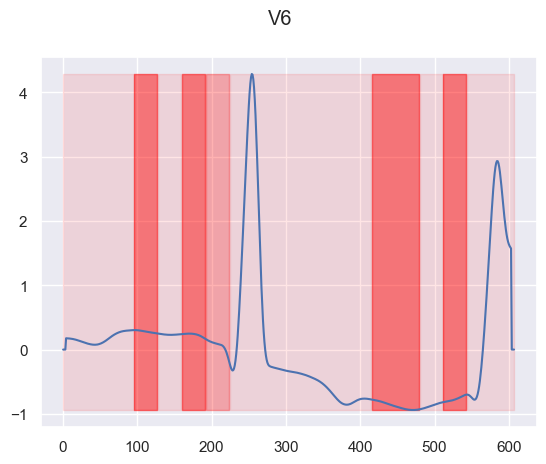

In [114]:
## visualize time attention
print (len(time_attention))
print(time_attention[0].shape)
## lead V2, 
lead_name = "V6"
lead_indice = {'I':0,'II':1,'III':2,'aVR':3,'aVL':4,'aVF':5,'V1':6,'V2':7,'V3':8,'V4':9,'V5':10,'V6':11}[lead_name]
lead_v2_time_attention = time_attention[lead_indice][indices]
print (lead_v2_time_attention.shape)
## first normalize
# def normalize_attention_matrix(attention_matrix):
#     ## attention_matrix: (num_leads,signal_length)
#     ## normalize each row
#     normaized = attention_matrix/attention_matrix.sum(axis=1,keepdims=True)
#     return normaized

lead_v2_time_attention = lead_v2_time_attention.mean(axis=0).cpu().detach().numpy()
print (lead_v2_time_attention.shape)
plt.figure()
# sns.heatmap(lead_v2_time_attention.cpu().detach().numpy(),cmap="YlGnBu")

## upscale the attention to the original signal length
upscaled_attention = np.repeat(lead_v2_time_attention,32)
## get convolved features:
input_feature = classification_net.encoder.input_conv_output
## sum every 4 features in channel dimension
# input_feature = input_feature

# print (input_feature.shape)
input_signal = data["input_seq"][indices][lead_indice].cpu().detach().numpy()
# print ('v2 signal')
top_quantile = np.quantile(upscaled_attention,0.75)
## draw the signal using color sampled from the attention weight
plt.figure()
plt.plot(input_signal)
## draw attention map as background color and remove the bounding box
plt.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=((upscaled_attention>upscaled_attention.mean())&(upscaled_attention<top_quantile)),color="red",alpha=0.3)
# plt.fill_between(np.arange(0,1024),input_signal.min(),input_signal.max(),where=upscaled_attention<upscaled_attention.mean(),color="blue",alpha=0.5)
plt.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=(upscaled_attention>=top_quantile),color="red",alpha=0.5)
plt.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=((upscaled_attention<upscaled_attention.mean())),color="red",alpha=0.1)
# plt.fill_between(np.arange(0,1024),input_signal.min(),input_signal.max(),where=(upscaled_attention==upscaled_attention.max()),color="red",alpha=0.7)
plt.suptitle(lead_name)
## remove bounding boxes

## remove ticks

12
(19,)


Text(0.5, 0.98, 'II')

<Figure size 640x480 with 0 Axes>

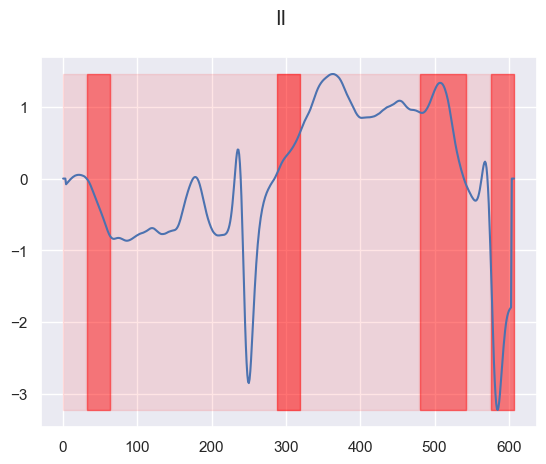

In [79]:
## visualize time attention
print (len(time_attention))
## lead V2, 
lead_name = "II"
lead_indice = {'I':0,'II':1,'III':2,'aVR':3,'aVL':4,'aVF':5,'V1':6,'V2':7,'V3':8,'V4':9,'V5':10,'V6':11}[lead_name]
lead_v2_time_attention = time_attention[lead_indice][indices]

lead_v2_time_attention = lead_v2_time_attention.mean(axis=0).cpu().detach().numpy()
print (lead_v2_time_attention.shape)
plt.figure()
# sns.heatmap(lead_v2_time_attention.cpu().detach().numpy(),cmap="YlGnBu")

## upscale the attention to the original signal length
upscaled_attention = np.repeat(lead_v2_time_attention,32)
## get convolved features:
input_feature = classification_net.encoder.input_conv_output
## sum every 4 features in channel dimension
# input_feature = input_feature

# print (input_feature.shape)
input_signal = data["input_seq"][indices][lead_indice].cpu().detach().numpy()
# print ('v2 signal')
top_quantile = np.quantile(upscaled_attention,0.75)
## draw the signal using color sampled from the attention weight
plt.figure()
plt.plot(input_signal)
## draw attention map as background color and remove the bounding box
plt.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=((upscaled_attention>upscaled_attention.mean())&(upscaled_attention<top_quantile)),color="red",alpha=0.3)
# plt.fill_between(np.arange(0,1024),input_signal.min(),input_signal.max(),where=upscaled_attention<upscaled_attention.mean(),color="blue",alpha=0.5)
plt.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=(upscaled_attention>=top_quantile),color="red",alpha=0.5)
plt.fill_between(np.arange(0,max_seq_len),input_signal.min(),input_signal.max(),where=((upscaled_attention<upscaled_attention.mean())),color="red",alpha=0.1)
# plt.fill_between(np.arange(0,1024),input_signal.min(),input_signal.max(),where=(upscaled_attention==upscaled_attention.max()),color="red",alpha=0.7)
plt.suptitle(lead_name)
## remove bounding boxes

## remove ticks

In [ ]:
# print (auroc.compute())
# print attention map
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12
rcParams['axes.linewidth'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.minor.width'] = 1.5
rcParams['ytick.minor.width'] = 1.5
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 5
rcParams['xtick.minor.size'] = 3
rcParams['ytick.minor.size'] = 3
rcParams['axes.spines.top'] = False

# def plot_attention_map(lead_attention,time_attention,lead_names,save_path=None):
#     """
#     lead_attention: (batch_size,12)
#     time_attention: (128,32,32)
#     lead_names: list of 12 lead names
#     """
#     batch_size = lead_attention.shape[0]
#     fig = plt.figure(figsize=(12, 8))
#     outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.2)
#     for i in range(batch_size):



In [ ]:
## visualize confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12
rcParams['axes.linewidth'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.minor.width'] = 1.5
rcParams['ytick.minor.width'] = 1.5
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 5
rcParams['xtick.minor.size'] = 3
rcParams['ytick.minor.size'] = 3
rcParams['axes.spines.top'] = False

# pred_npy = np.load("/home/engs2522/project/multi-modal-heart/log_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_ms_resnet/classfication_result/test_pred.npy")
# gt_npy = np.load("/home/engs2522/project/multi-modal-heart/log_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_ms_resnet/classfication_result/test_gt.npy")

pred_npy = np.load("/home/engs2522/project/multi-modal-heart/log_finetune/resnet1d101_512+benchmark_classifier_ms_resnet/classfication_result/test_pred.npy")
gt_npy = np.load("/home/engs2522/project/multi-modal-heart/log_finetune/resnet1d101_512+benchmark_classifier_ms_resnet/classfication_result/test_gt.npy")



(2163, 5)
(2163, 5)
(5, 2, 2)


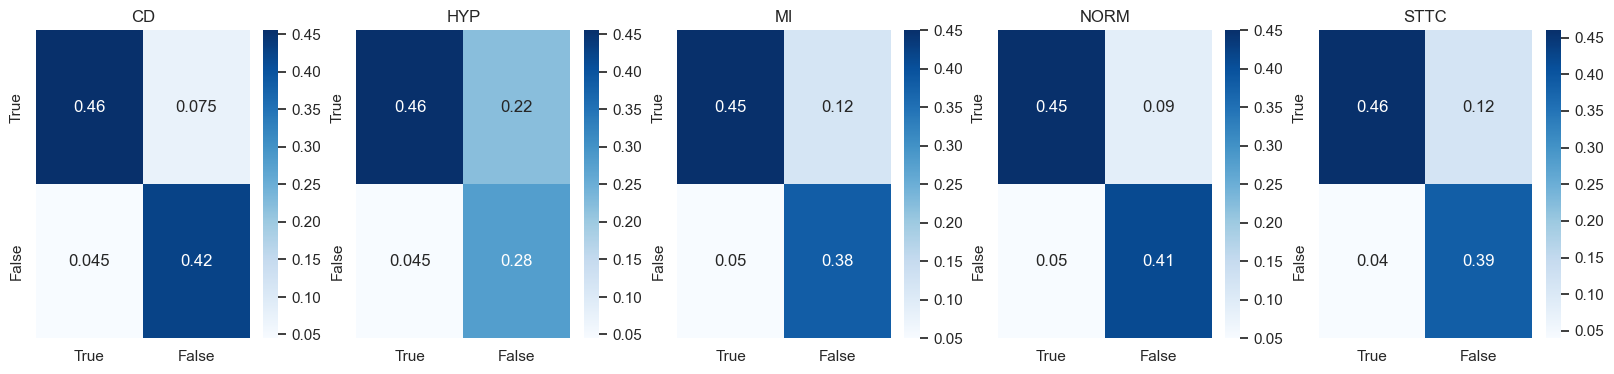

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn
import pandas as pd
y_pred = pred_npy>=0.5
y_pred = y_pred.astype(int)
y_true = gt_npy.astype(int)
print (y_pred.shape)
print (y_true.shape)
cm = multilabel_confusion_matrix(y_true, y_pred, labels = [0,1,2,3,4])
## plot confusion matrix
classes = dataset.super_classes_labels
print (cm.shape)

# df_cm = pd.DataFrame(cm, range(len(classes)), range(len(classes)))
# # plt.figure(figsize=(10,7))
# sn.set(font_scale=1.4) # for label size
# sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
# # plt.show()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.round(cm,2)

fig, axes = plt.subplots(1,5,figsize=(20,4))
for i,a_class in enumerate(classes):
    ax = axes[i]
    # im = ax.imshow(cm[i], interpolation='nearest', cmap=plt.cm.Blues)
    cmi = cm[i]
    con = np.zeros((2,2))
    for x in range(2):
        for y in range(2):
            con[x,y] = cmi[x,y]/np.sum(cm[x,:])
    sns.set(font_scale=1.0) # for label size
    df = sns.heatmap(con, annot=True,fmt='.2', cmap='Blues',xticklabels= ['True', 'False'] , yticklabels= ['True','False'],ax=axes[i])
    df.set_title(a_class)



In [ ]:
## load median wave model
ecg_net_median = ECGAttentionAE(num_leads=12, time_steps=608, z_dims=512, linear_out=512, downsample_factor=5, base_feature_dim=4,if_VAE=False,use_attention_pool=False,no_linear_in_E=True)
classification_net_median = LitClassifier(encoder=ecg_net_median.encoder,input_dim=512,num_classes=5)
# classification_net_median.load_from_checkpoint("/home/engs2522/project/multi-modal-heart/log_median_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_ms_resnet/checkpoints/epoch=01-val_auroc:benchmark_classifier/val_macro_auc=0.78.ckpt")

no linear layer


/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(


In [ ]:
## load median wave dataset
median_dataset = ECGDataset(data_folder,label_csv_path=test_data_statement_path,
                         use_median_wave=True, ## set to median wave, then it has 600 samples for each lead, when sampling rate is 100
                          sampling_rate=500,
                          max_seq_len=608,
                          augmentation= False,
                          data_proc_config=data_proc_config,
                          data_aug_config=data_aug_config,)
median_data_loader = DataLoader(dataset=median_dataset,
                            batch_size=batch_size,
                            num_workers=0,
                            shuffle = True,
                            drop_last= False,
                            )
print ('load {} data: {} samples'.format(test_data_statement_path.split("/")[-1],len(dataset)))
    

load Y_test.csv data: 2163 samples


In [ ]:
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics.classification import MultilabelAUROC
from tqdm.notebook import tqdm
metric = MultilabelAccuracy(num_labels=5)
auroc = MultilabelAUROC(num_labels=5)
classification_net_median.eval()
for i, data in enumerate(tqdm(median_data_loader)):
    torch.cuda.empty_cache()
    # ecg_id= data['ecg_id']
    pred = classification_net_median(data["input_seq"])
    report   =data["report"]
    pred = torch.sigmoid(pred)
    ground_truth = data["super_class_encoding"]
    # print (ground_truth.shape)
    acc = metric.update(pred, ground_truth.long())
    auroc_score = auroc.update(pred, ground_truth.long())
    try:
        lead_attention,time_attention = classification_net_median.encoder.get_attention()
        print (lead_attention.shape[5:10])
    except:
        pass
    print (report[5:10])
    print (pred[5:10])
    print (ground_truth[5:10])
    print (acc)
    print (auroc_score)
    if ground_truth[0][3]==1:
        break
     

  0%|          | 0/17 [00:00<?, ?it/s]

TypeError: forward() missing 1 required positional argument: 'mask'